# Import and Data

In [12]:
from tqdm import tqdm_notebook as tqdm
import numpy as np

import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

num_workers = 4
batch_size = 200

# percentage of training set to use as validation
valid_size = 0.2

# with augmentation
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                ])

train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# obtain indices used for validation from training data
all_indices = list(range(len(train_data)))
np.random.shuffle(all_indices)

split = int(np.floor(valid_size * len(train_data)))
train_idx, valid_idx = all_indices[split:], all_indices[:split]

# define sampler and dataloader
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size=batch_size,
                            sampler=train_sampler, num_workers=num_workers)
val_loader = DataLoader(train_data, batch_size=batch_size,
                            sampler=valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size,
                            num_workers=num_workers)

# class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = False
!nvidia-smi

Files already downloaded and verified
Files already downloaded and verified
Sun Sep  8 09:43:06 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    71W / 149W |   1493MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:

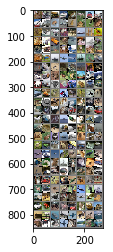

(200, 3, 32, 32)


In [13]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
images = images.numpy()

print(images.shape)

In [0]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)
#print(vgg16)

# Define the CNN Architecture

In [0]:
class ConvMcifar(nn.Module):
    def __init__(self):
        super(ConvMcifar, self).__init__()

        # conv layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256,256, kernel_size=3, stride=1, padding=1)


        # affine layers
        self.fc1 = nn.Linear(4096, 800)
        self.fc2 = nn.Linear(800,200)
        self.fc3 = nn.Linear(200,10)

        # pooling, dropout, batchnorm
        self.dropout_conv = nn.Dropout2d(0.2)
        self.dropout_fc = nn.Dropout2d(0.5)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.batch1 = nn.BatchNorm2d(64)
        self.batch2 = nn.BatchNorm2d(64)
        self.batch3 = nn.BatchNorm2d(128)
        self.batch4 = nn.BatchNorm2d(128)
        self.batch5 = nn.BatchNorm2d(256)
        self.batch6 = nn.BatchNorm2d(256)


    def forward(self, x):

        x = F.leaky_relu(self.batch1(self.conv1(x)), 0.2)
        x = self.dropout_conv(x)

        x = F.leaky_relu(self.batch2(self.conv2(x)), 0.2)
        x = self.maxpool(x)
        x = self.dropout_conv(x)

        x = F.leaky_relu(self.batch3(self.conv3(x)), 0.2)
        x = self.dropout_conv(x)

        x = F.leaky_relu(self.batch4(self.conv4(x)), 0.2)
        x = self.maxpool(x)
        x = self.dropout_conv(x)

        x = F.leaky_relu(self.batch5(self.conv5(x)), 0.2)
        x = self.dropout_conv(x)

        x = F.leaky_relu(self.batch6(self.conv6(x)), 0.2)
        x = self.maxpool(x)
        x = self.dropout_conv(x)

        #print(self.num_flat_features(x))
        x = x.view(-1, self.num_flat_features(x))

        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)

        x = F.relu(self.fc2(x))
        x = self.dropout_fc(x)

        x = self.fc3(x)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Training Model

In [16]:
num_epochs = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = False

model = ConvMcifar()
model.to(device)

# loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08)

val_loss_min = np.Inf

for epoch in tqdm(range(num_epochs)):

    #####################
    ## train the model ##
    #####################

    train_loss = 0.0
    model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().item()*data.size(0)  # accounts for change in batch_size

    # calculate average loss
    train_loss = train_loss/len(train_loader.dataset)
    scheduler.step(train_loss)

    #####################
    ### val the model ###
    #####################

    val_loss = 0.0
    model.eval()

    for data, target in val_loader:
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)

        val_loss += loss.cpu().item()*data.size(0)

    # calculate average loss
    val_loss =  val_loss/len(val_loader.dataset)

    print("Epoch: {} | Training Loss: {:.4f} | Val Loss: {:.4f} |".format(epoch, train_loss, val_loss))

    # save model if validation loss has decreased
    if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        val_loss_min,
        val_loss))
        
        torch.save(model.state_dict(), 'model_cifar.pt')
        val_loss_min = val_loss





Epoch: 0 | Training Loss: 1.4346 | Val Loss: 0.2823 |
Validation loss decreased (inf --> 0.282279).  Saving model ...
Epoch: 1 | Training Loss: 1.1825 | Val Loss: 0.2426 |
Validation loss decreased (0.282279 --> 0.242649).  Saving model ...
Epoch: 2 | Training Loss: 1.0616 | Val Loss: 0.2284 |
Validation loss decreased (0.242649 --> 0.228412).  Saving model ...
Epoch: 3 | Training Loss: 0.9731 | Val Loss: 0.1983 |
Validation loss decreased (0.228412 --> 0.198270).  Saving model ...
Epoch: 4 | Training Loss: 0.9011 | Val Loss: 0.1871 |
Validation loss decreased (0.198270 --> 0.187052).  Saving model ...
Epoch: 5 | Training Loss: 0.8503 | Val Loss: 0.1723 |
Validation loss decreased (0.187052 --> 0.172334).  Saving model ...
Epoch: 6 | Training Loss: 0.8021 | Val Loss: 0.1641 |
Validation loss decreased (0.172334 --> 0.164130).  Saving model ...
Epoch: 7 | Training Loss: 0.7571 | Val Loss: 0.1549 |
Validation loss decreased (0.164130 --> 0.154908).  Saving model ...
Epoch: 8 | Training L

# Test the Network after training

In [32]:
# Load Model
model.load_state_dict(torch.load('model_cifar.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [33]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

#####################
### test the model ##
#####################

test_loss = 0.0
model.eval()

for data, target in test_loader:
    data, target = data.to(device), target.to(device)

    output = model(data)
    loss = criterion(output, target)

    test_loss += loss.cpu().item()*data.size(0)

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.438969

Test Accuracy of airplane: 86% (863/1000)
Test Accuracy of automobile: 93% (933/1000)
Test Accuracy of  bird: 78% (786/1000)
Test Accuracy of   cat: 68% (680/1000)
Test Accuracy of  deer: 84% (849/1000)
Test Accuracy of   dog: 79% (796/1000)
Test Accuracy of  frog: 90% (902/1000)
Test Accuracy of horse: 89% (899/1000)
Test Accuracy of  ship: 93% (932/1000)
Test Accuracy of truck: 90% (903/1000)

Test Accuracy (Overall): 85% (8543/10000)


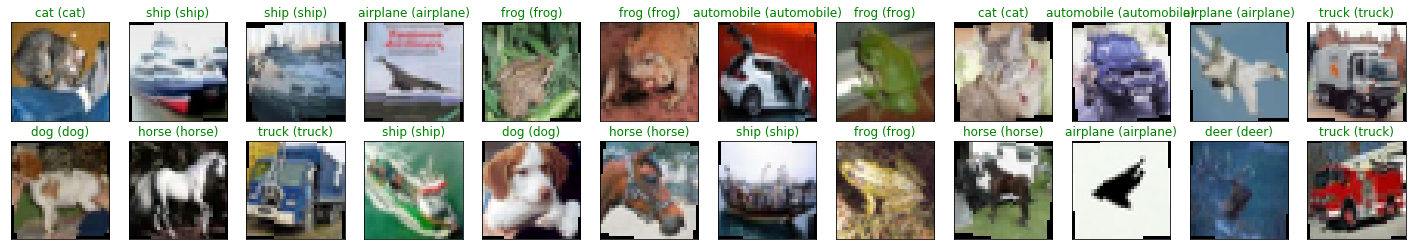

In [34]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

images = images.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy())

images = images.cpu()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(24):
    ax = fig.add_subplot(2, 24/2, idx+1, xticks=[], yticks=[])
    img = images[idx] / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
    
plt.show()

# Visualize Kernels and Features

## Weights of the kernels of 1st convolutional layer 

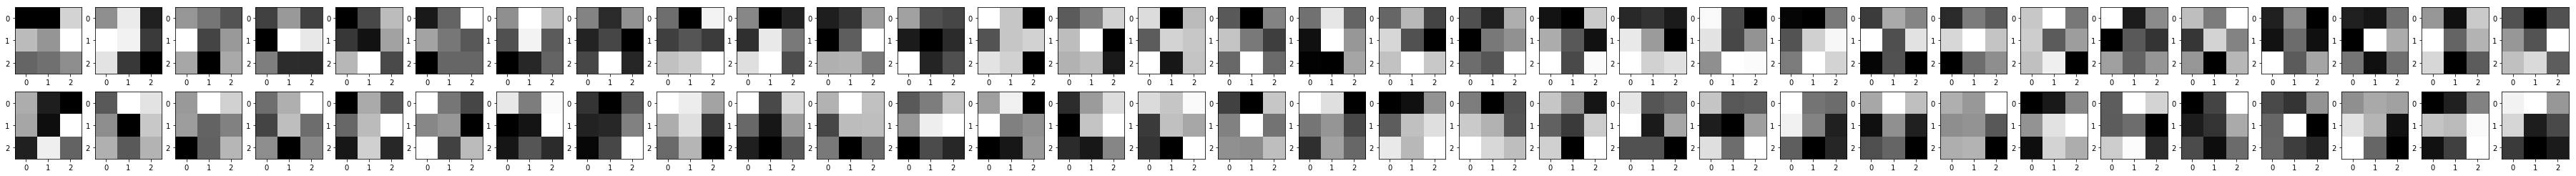

In [42]:
weights = model.conv1.weight.data
w = weights.cpu().numpy()

fig = plt.figure(figsize=(64,4))
columns = 32
rows = 2

for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    ax.set_title("Kernel ({})".format(i))

plt.show()

(3, 32, 32)


Text(0.5, 1.0, 'automobile')

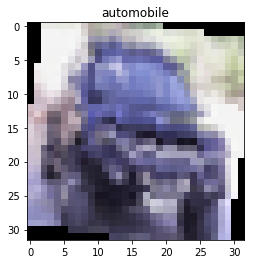

In [76]:
# applying above weights one at a time to a sample image
# this visualizes the features learned in the first convolutional layer

import cv2
# Using OpenCv's filter2D function to apply these filters to a sample image
# Producing a series of filtered outputs

dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# selecting one image
idx = 9
image = np.squeeze(images[idx])
print(image.shape)
img = image / 2 + 0.5     # unnormalize
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.title("{}".format(classes[labels[idx]]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


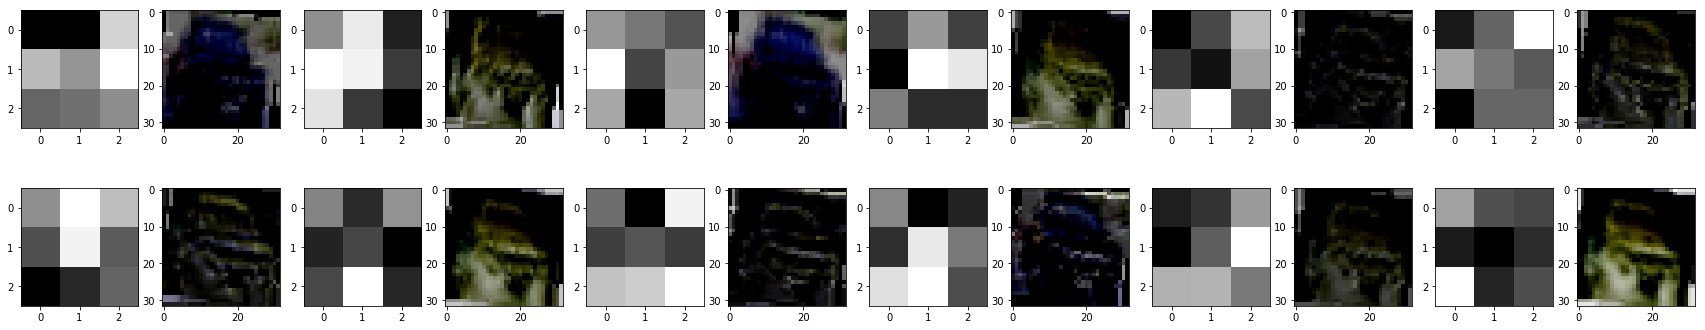

In [78]:
# applying a set of filters weights

weights = model.conv1.weight.data
w = weights.cpu().numpy()

# first conv layer for first 10 filters
fig=plt.figure(figsize=(30, 6))
columns = 6*2
rows = 2

image = np.squeeze(images[idx])
image = np.transpose(image, (1, 2, 0))
imgage = image / 2 + 0.5     # unnormalize
print(image.shape)

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(image, -1, w[int((i-1)/2)][0])
        plt.imshow(c)
plt.show()
